In [1]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
!pip install emoji_extractor
!pip install emoji
import sys  
!{sys.executable} -m pip install contractions
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
# Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip

--2021-04-18 16:50:49--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv [following]
--2021-04-18 16:50:50--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113587 (111K) [text/plain]
Saving to: ‘datos_twitter_master.tsv’

datos_twitter_maste 100%[===================>] 110.92K  --.-KB/s    in 0.03s   

2021-04-18 16:50:50 (4.30 MB/s) - ‘dato

# Ejercicio 3 (30%)

El objetivo de este ejercicio es comprobar los conocimientos adquiridos por el alumno en temas relacionados al entrenamiento de modelos de clasificación con características de análisis de sentimiento.

En esta ocasión teneis que entrenar un modelo de clasificación que además de considerar las características de TFIDF debe tener en cuenta al menos algunas características extras como el sentimiento y objetividad de las frases utilizando librerías externas. 

En este ejercicio, muy similar al ejercicio de [Twitter Classification](https://colab.research.google.com/drive/19ZpXH_P_4TKt4xspEaEZrYg-MeWQksSP#scrollTo=tSCQn96RT3mU) se pide que repliqueis la estructura para generar un modelo de clasificación de los datos del dataset.

El dataset se descargo utilizando la API de Twitter, recopilando los datos que mencionaran la palabra "noise". Cada tweet tiene una etiqueta en la columna  "Molestia". El valor de esa etiqueta representa lo siguiente:

- *Valor 1*: Tweets con la palabra ruido que hacen referencia a molestias sufridas por ruido acústico proveniente de distintas fuentes (coches, vecinos, mascotas,...)
- *Valor 0*: Tweets que contienen la palabra ruido perso no expresan una molestia sufrida por el usuario que lo escribió. Aquí se incluyen tweets que hacen referencia a noticias sobre ruido, a una valoración del ruido acústico como algo positivo, u otras acepciones de la palabra ruido (mediatic noise). 

Dado que el ejercicio es muy similar al compartido, se pide que:

- Repliqueis los pasos en la generación del modelo explicando con vuestras palabras cada uno de los procesos. (30%)
- Incorporeis características de sentimiento del texto (utilizando librerías como Textblob) además de las caracteristicas TFIDF. (40%)
- Una vez entrenado el modelo, extraigais el nombre de las 10 características más importantes (30%).



> Nota 1: Cualquier cálculo adicional al visto en clase (visualizaciones, nuevas características añadidas al modelo, distribuciones por clase...) será valorado positivamente en la calificación.

> Nota 2: Insisto en seguir la estructura de análisis en tres fases vista en clase. Esto os facilitará llevar un orden en el análisis, explicar los pasos de forma estructurada y clara, y conseguir una mejor calificación.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import contractions
import re
from emoji_extractor.extract import Extractor
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report


---------------------------------------------------------------------------

## Funciones

Generamos las funciones que vamos a utilizar a lo largo del script.

In [3]:
# Preparar diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

In [4]:
# Reemplazar contracciones y slang en inglés usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    # Divide el texto
    for t in text.split():
        # Aplica la función fix en cada sección o token del texto buscando contracciones y slang
        expanded_words.append(contractions.fix(t, slang = True))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Hay un tokenizador guay para twitter https://github.com/jaredks/tweetokenize



In [6]:
# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

In [7]:
# Calcula el sentimiento de los emojis de una lista utilizando el diccionario
# de emoji sentiment score generado previamente con la función load_emoji_sentiment()
# Se puede extraer el valor de positividad de los emojis con la option "positive"
# Se puede extraer el valor de neutralidad de los emojis con la option "neutral""  
# Se puede extraer el valor de e negatividad de los emojis con la option "negative""  

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e: 
      continue
  return output

In [8]:
# Eliminar los emojis de un texto. Esto es útil porque una vez extraido los emojis
# puede interesarnos tener un texto sin presencia de emojis para mejor análisis.
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

In [10]:
# Tokenizar los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

# Quitar stop words de una lista de tokens
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación de una lista de tokens
# (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatization de los tokens. Devuelve una string entera para hacer la tokenización
# con NLTK
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)

-------------------------------------------------------------

## Cargar y Preparar datos

Cargamos los datos que vamos a utilizar:

In [11]:
# Datos twitter
dataset = pd.read_csv("datos_twitter_master.tsv", sep="\t") #Siempre separar por t porque los textos tienen comas
dataset

,tweet_text,molestia
0,Noise harassment is a sensation pain based tor...,1
1,It's 4.30am and we still haven't slept because...,1
2,These birds acting like I can't grab my chains...,1
3,Why do people leave the annoying tap-tap keybo...,1
4,Please would you keep the noise down? We're re...,1
...,...,...
1015,I come alive when I hear your voice it's a bea...,0
1016,"I'm currently in Ripon, the noise of the thund...",0
1017,Sitting down the weir and the noise of the wat...,0
1018,The sound of a beer can being cracked open is ...,0


In [12]:
# Emojis
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")
emoji_sent_dict

{'¦': {'Negative': 0.175,
  'Neutral': 0.025,
  'Occurrences': 40,
  'Position': 0.402048475,
  'Positive': 0.8,
  'Unicode block': 'Latin-1 Supplement',
  'Unicode codepoint': '0xa6',
  'Unicode name': 'BROKEN BAR'},
 '©': {'Negative': 0.12980769230769232,
  'Neutral': 0.6225961538461539,
  'Occurrences': 416,
  'Position': 0.7401483759999999,
  'Positive': 0.24759615384615385,
  'Unicode block': 'Latin-1 Supplement',
  'Unicode codepoint': '0xa9',
  'Unicode name': 'COPYRIGHT SIGN'},
 '®': {'Negative': 0.06569343065693431,
  'Neutral': 0.583941605839416,
  'Occurrences': 137,
  'Position': 0.353084876,
  'Positive': 0.35036496350364965,
  'Unicode block': 'Latin-1 Supplement',
  'Unicode codepoint': '0xae',
  'Unicode name': 'REGISTERED SIGN'},
 '҂': {'Negative': 1.0,
  'Neutral': 0.0,
  'Occurrences': 1,
  'Position': 0.519230769,
  'Positive': 0.0,
  'Unicode block': 'Cyrillic',
  'Unicode codepoint': '0x482',
  'Unicode name': 'CYRILLIC THOUSANDS SIGN'},
 '۞': {'Negative': 0.0,
  

-------------------------------------------------------------------------------

## Análisis Preliminar

Una vez cargados, vamos a hacer un análisis exploratorio de los datos:
- Número de documentos
- Número de columnas
- Duplicados
- Valores vacíos
- Distribución de clases
- Distribución de longitudes

In [13]:
# Número de documentos
print("Tenemos un conjunto de {} tweets".format(len(dataset)))

# Número de columnas
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 1020 tweets
El dataframe tiene 2 columnas


In [14]:
# Número de duplicados 
print("Existen {} tweets duplicados".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} tweets".format(dataset.shape[0]))

Existen 1 tweets duplicados
Despues de quitar duplicados tenemos un conjunto de 1019 tweets


In [15]:
# Valores vacíos
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],                                                                                                     np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


In [16]:
# Distribución de clases
dataset["molestia"].value_counts()

1    510
0    509
Name: molestia, dtype: int64

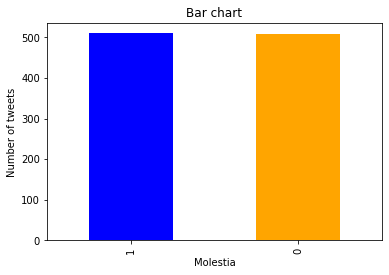

In [17]:
ax, fig = plt.subplots()
etiquetas = dataset.molestia.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.ylabel('Number of tweets')
plt.xlabel('Molestia')
plt.show()

Vemos que en la columna "molestia" nos encontramos las etiquetas del dataset. En este caso nos encontramos dos tipos de documentos (tweets):

- "Molestia = 1": Tweets con la palabra ruido que hacen referencia a molestias sufridas por ruido acústico proveniente de distintas fuentes (coches, vecinos, mascotas,...)
- "Molestia = 0": Tweets que contienen la palabra ruido perso no expresan una molestia sufrida por el usuario que lo escribió. Aquí se incluyen tweets que hacen referencia a noticias sobre ruido, a una valoración del ruido acústico como algo positivo, u otras acepciones de la palabra ruido (mediatic noise). 

Ahora vamos a graficar la distribución de las longitudes de cada tweet por cada valor de la clase:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fig

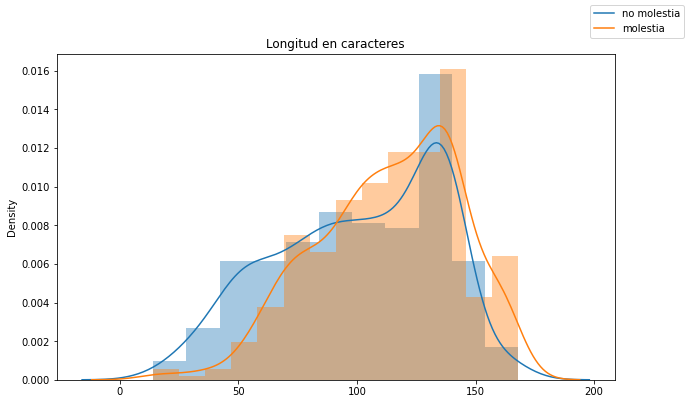

In [18]:
# Distribución de longitudes
## Calculamos la variable longitud
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

## Dibujamos la distribución de longitudes
fig = plt.figure(figsize=(10,6))
plt1 = sns.distplot(dataset[dataset["molestia"]==1]["char_len"].to_list(), hist=True, label="molestia")
plt2 = sns.distplot(dataset[dataset["molestia"]==0]["char_len"].to_list(), hist=True, label="no molestia")
fig.legend(labels=['no molestia','molestia'])
plt.title("Longitud en caracteres")
plt.show()

Vemos que no existen diferencias muy grandes entre ambas clases ya que las distribuciones más o menos se solapan, aunque se podría decir que los tweets clasificados como clase 1 ("molestia = 1") parecen en general más cortos.

---------------------------------------------------------------------------------

## Transformación

1º. Normalización/Preprocesado

2º. Transformación

### 1º. Normalización

Vamos a seguir los pasos para el preprocesado de los datos tanto de los tweets como de los emojis:

- Por una parte vamos a extraer los emojis de los tweets, los vamos a guardar en una lista dentro de una nueva columna del dataframe y por último calcularemos un valor de sentimiento de emojis de positividad, negatividad y neutralidad.

- Preprocesar los textos:
    - Primero expanderemos las contracciones de los tweets
    - Despues quitaremos los emojis, ya que antes habremos calculado los scores necesarios.
    - Tokenizaremos
    - Quitaremos stop words
    - Quitaremos puntuación
    - Lematizaremos

**EMOJIS**

Primero vamos a crear un **score de sentimiento** para cada emoji. Para ello, primero creamos una lista que contenga únicamente los emojis de los tweets:

In [19]:
dataset["emoji_list"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))
dataset["emoji_list"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        []
1        []
2        []
3        []
4       [🎻]
       ... 
1015     []
1016     []
1017     []
1018     []
1019     []
Name: emoji_list, Length: 1019, dtype: object

Continuamos calculando una puntuación de sentimiento a los emojis para clasificarles en positivos, negativos o neutros. Para aquellos elementos que no se clasifiquen como positivos, negativos o neutros recibirán un valor 0.

In [20]:
dataset["sent_emoji_pos"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x,"positive")) #positive
dataset["sent_emoji_neu"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x,"neutral")) #neutral
dataset["sent_emoji_neg"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x,"negative")) #negative

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [21]:
dataset["sent_emoji_neu"]

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.555556
          ...   
1015    0.000000
1016    0.000000
1017    0.000000
1018    0.000000
1019    0.000000
Name: sent_emoji_neu, Length: 1019, dtype: float64

###TWEETS

Viendo la lista creada vemos aquellos tweets que se han clasificado en este caso como neutros.


Una vez generado el score, preprocesamos los textos con las funciones generadas previamente.

- Reemplazamos las contracciones por palabras utilizando la función replace_contractions.

- Quitamos los emojis de los textos porque ya hemos calculado el score, que es realmente lo que nos interesa.

- Una vez finalizado, tokenizamos los tweets y los preprocesamos (stop words, símbolos de puntuación y lematización). Representamos su distribución por clases.

- Generamos nuevas características para mejorar el algoritmo a partir de la librería TextBlob para obtener medidas de sentimiento de cada tweet.


In [22]:
# Reemplazar contracciones
dataset["tweet_text_processed"] = dataset["tweet_text"].apply(lambda x: replace_contraction(x))
# Quitar emojis de los textos
dataset["tweet_text_processed"] = dataset["tweet_text_processed"].apply(lambda x: clean_emoji(x))  #CleanEmoji de tweet_text_processed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
# Tokenizamos
dataset["tokenized"] = dataset["tweet_text_processed"].apply(lambda x: tokenize(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# Quitar stopwords
dataset["tokenized_clean"] = dataset["tokenized"].apply(lambda x: quitar_stopwords(x)) #quitar_stopwords
# Quitamos los símbolos de puntuación
dataset["tokenized_clean"] = dataset["tokenized_clean"].apply(lambda x: quitar_puntuacion(x)) #quitar_puntuacion
# Lematizamos
dataset["lematizacion"] = dataset["tokenized_clean"].apply(lambda x: lematizar(x)) #lematizar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Ahora representamos graficamente la longitud en tokens de cada uno de los tweets:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level funct

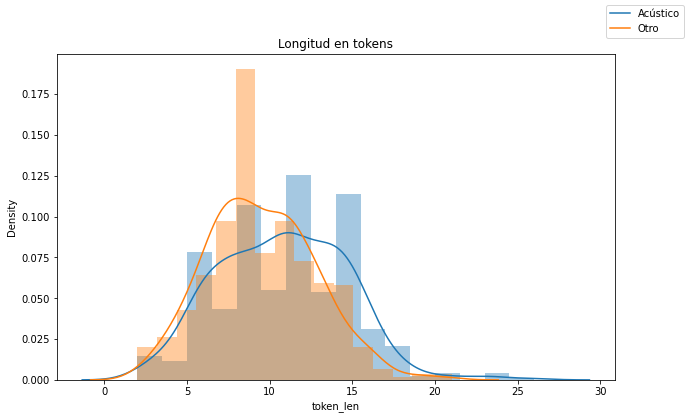

In [25]:
# Longitud en tokens de los textos
dataset["token_len"] = dataset["lematizacion"].apply(lambda x: len(x.split()))


fig = plt.figure(figsize=(10,6))
plt1 = sns.distplot(dataset[dataset["molestia"]==1]["token_len"], hist=True, label="Acústico")
plt2 = sns.distplot(dataset[dataset["molestia"]==0]["token_len"], hist=True, label="Otro")
fig.legend(labels=['Acústico','Otro'])
plt.title("Longitud en tokens")
plt.show()

Observando el gráfico de la distribución,vemos que tampoco existen diferencias muy grandes entre ambas clases. Aunque en general parece que los tokens clasificados como clase 1, otro acepción de ruido ("molestia = 0"), parecen en general más cortos.


A continuación vamos a generar también puntuaciones de subjetividad y polaridad de cada uno de los tweets con textblob y los añadimos al dataset.

In [26]:
from textblob import TextBlob

def sentiment(lematizacion):
    try:
        return TextBlob(lematizacion).sentiment
    except:
        return None

In [27]:
dataset['Polarity']= dataset['lematizacion'].apply(sentiment).apply(lambda x:  x[0])
dataset['Subjectivity'] = dataset['lematizacion'].apply(sentiment).apply(lambda x: x[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-------------------------------------------------------------------------------------

## Vectorización

Una vez hemos limpiado y procesado el texto, vamos a extraer características utilizando TFIDFVectorizer:

Escogeremos los parámetros utilizados TfidfVectorizer del ejercicio 2:
*   Se consideren unigramas, bigramas y trigramas
*   No se tengan en cuenta los elementos que aparezcan en menos del 5% de los textos 
*   Se utilice el tokenizador incorporado en Scikit-Learn. 
*   Haya un máximo de 100 características (ponemos 100 porque no hay muchos datos). 



In [28]:
# BoW Features
vectorizador = TfidfVectorizer(min_df=0.05, ngram_range = (1,3),  smooth_idf = True, max_features = 100)
vector_data = vectorizador.fit_transform(dataset["lematizacion"])

-------------------------------------------------------------------------

## Entrenar/Testear el clasificador

Vamos a introducir otras características que pueden influir para mejorar el rendimiento del clasificador como las variables de sentimiento de emojis o las de polaridad y subjetividad de los tweets.

Para ello, primero las almacenamos en una matriz:


In [29]:
extra_features = dataset[['sent_emoji_pos','sent_emoji_neg','sent_emoji_neu','Polarity','Subjectivity']]

In [30]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset["molestia"].values.astype(np.float32) 
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe  
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

Extraemos también el nombre de las características porque puede ser útil.

In [31]:
X_columns=vectorizador.get_feature_names()+extra_features.columns.tolist()

Spliteamos en train y test:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(764, 19)
(255, 19)


Grid search:

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [34]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


A continuación, entrenamos el grid_search para obtener los mejores parámetros para este conjunto de datos.

In [35]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))


Mejor accuracy: 0.761928 usando los parámetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [40]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=100, penalty="l2", solver = "newton-cg")
model.fit(X_train,y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
 

[[113  20]
 [ 35  87]]
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       133
         1.0       0.81      0.71      0.76       122

    accuracy                           0.78       255
   macro avg       0.79      0.78      0.78       255
weighted avg       0.79      0.78      0.78       255



____________________________________________________________________

##10 CARACTERÍSTICAS MÁS IMPORTANTES

Vamos a agrupar la columna con los nombres de las características y sus importancias en un dataframe. A continuación, ordenaremos por importance de forma descendente y limitaremos la salida a las 10 características con mayor puntuación. 

Como tenemos puntuaciones negativas al ordenar nos las colocaría al final, por tanto cogeremos las importancias en valor absoluto para centrarnos solo en el valor. Estas características son por ejemplo Polarity y Subjectivity.

En primer lugar, convertimos la columna de importancias a una lista y junto con la de los nombres las agrupamos en un dataframe.

In [43]:
importance=abs(model.coef_[0]).tolist()

In [44]:
df = pd.DataFrame(list(zip(X_columns,importance)), columns = ['Names','Importance'])
print(df)

              Names  Importance
0               get    2.191899
1              hear    1.836967
2              like    2.170106
3              loud    2.972546
4              make    2.351834
5         make much    3.191993
6        make noise    2.757792
7              much    2.858544
8        much noise    2.816034
9             noise    1.684124
10  noise pollution    0.821612
11        pollution    0.592637
12            sleep    3.186552
13              the    2.134636
14   sent_emoji_pos    1.507974
15   sent_emoji_neg    4.754283
16   sent_emoji_neu    0.271878
17         Polarity    2.398047
18     Subjectivity    0.845310


Finalmente, ordenamos por la columna Importance el dataframe de forma descendente y limitamos la salida a las 10 primeras características.

In [45]:
df=df.sort_values(by= 'Importance', ascending=False)[0:10]
df


,Names,Importance
15,sent_emoji_neg,4.754283
5,make much,3.191993
12,sleep,3.186552
3,loud,2.972546
7,much,2.858544
8,much noise,2.816034
6,make noise,2.757792
17,Polarity,2.398047
4,make,2.351834
0,get,2.191899


Como vemos, Polarity tiene una importancia en valor absoluto superior a otras características. Por tanto, si no hubiéramos seleccionado el valor absoluto no nos hubiera aparecido esta característica. Aunque es importante recordar a la hora de interpretarla que es un coeficiente negativo.

Text(0.5, 0, 'Características')

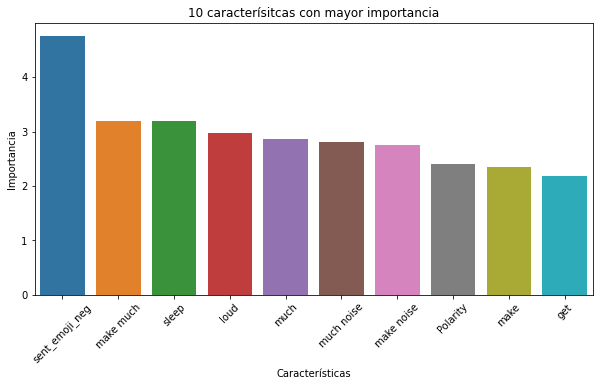

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10,5]
sns_g = sns.barplot(x=df['Names'], y=df['Importance'])
plt.xticks(rotation=45)
plt.title("10 caracterísitcas con mayor importancia")
plt.ylabel("Importancia")
plt.xlabel("Características")

____________________________________________________________________________